## Package and helper imports

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score
from simpletransformers.classification import ClassificationModel
import torch
# from transformers import TrainingArguments, Trainer
# from transformers import BertTokenizer, BertForSequenceClassification
# from transformers import EarlyStoppingCallback
import pickle
import pyarrow
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\schellr2\Anaconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import requests
url = "https://huggingface.co/"
requests.get(url, verify=True)

<Response [200]>

In [3]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices())

2.10.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9292393150121664513
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1742602240
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3328263902925138058
 physical_device_desc: "device: 0, name: NVIDIA RTX A2000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

## Define text cleaning function

In [5]:
def clean_text(df):
    for i in [char for char in ':;"?,/|\}{1234567890.~!@#$%^&*_+=<>']:
        df.text=df.text.apply(lambda x: str(x).replace(i,""))

    df.text=df.text.apply(lambda x: str(x).replace('-'," "))
    return df

## Import data

In [6]:
data = pd.read_parquet('./input/consumer_complaints.parquet')
data.head(10)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",None,None,None,U.S. Bancorp,CA,95993,None,None,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",None,None,None,Wells Fargo & Company,CA,91104,None,None,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,None,Incorrect information on credit report,Account status,None,None,Wells Fargo & Company,NY,11764,None,None,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,None,None,"Navient Solutions, Inc.",MD,21402,None,None,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,None,None,Resurgent Capital Services L.P.,GA,30106,None,None,Web,08/30/2013,Closed with explanation,Yes,Yes,511067
5,08/30/2013,Credit card,None,Application processing delay,None,None,None,Capital One,NY,12206,None,None,Phone,09/03/2013,Closed with explanation,Yes,Yes,510098
6,08/30/2013,Credit card,None,Credit line increase/decrease,None,None,None,Wells Fargo & Company,AZ,85730,None,None,Postal mail,09/05/2013,Closed with explanation,Yes,No,511062
7,08/30/2013,Bank account or service,Checking account,Deposits and withdrawals,None,None,None,Bank of America,IL,60660,None,None,Referral,09/04/2013,Closed with explanation,Yes,No,511116
8,08/30/2013,Bank account or service,Checking account,Deposits and withdrawals,None,None,None,Bank of America,GA,30016,None,None,Referral,09/04/2013,Closed with explanation,Yes,No,511091
9,09/17/2013,Mortgage,Conventional adjustable mortgage (ARM),"Loan modification,collection,foreclosure",None,None,None,"SunTrust Banks, Inc.",CA,94551,None,None,Web,09/18/2013,Closed with explanation,Yes,Yes,530602


In [7]:
# save data to df so won't have to reload data if need to start over with df.
df = data.copy()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

In [9]:
# Only keep records with a complaint narrative
df = df[~df['consumer_complaint_narrative'].isnull()]

In [10]:
# Only keep complaint narrative & product columns to see how well diff methods predict product from just text
df = df[['consumer_complaint_narrative', 'product']]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66806 entries, 190126 to 553096
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   consumer_complaint_narrative  66806 non-null  object
 1   product                       66806 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [12]:
df.shape

(66806, 2)

In [13]:
list(df.columns)

['consumer_complaint_narrative', 'product']

In [14]:
product = df['product'].value_counts()
print(product)

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: product, dtype: int64


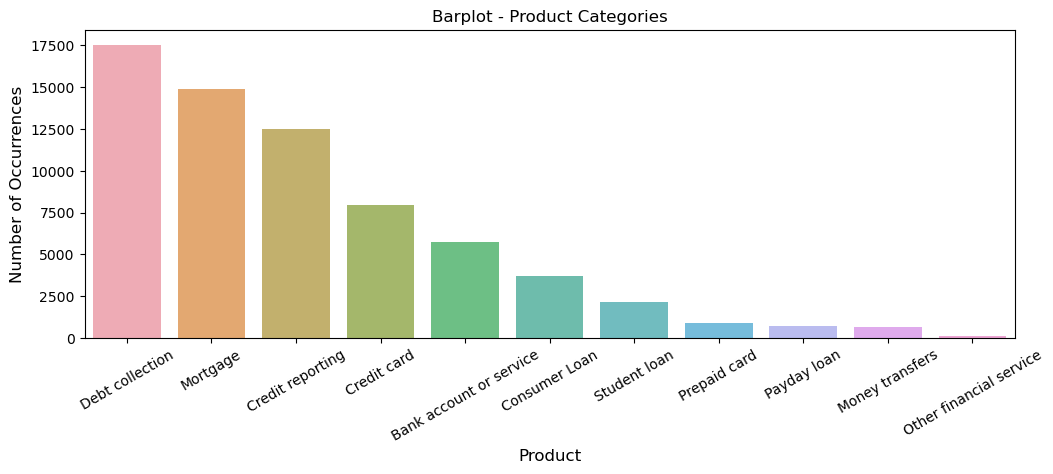

In [15]:
plt.figure(figsize=(12,4))
sns.barplot(x=product.index, y=product.values, alpha=0.8)
plt.title('Barplot - Product Categories')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=30)
plt.show()

In [16]:
for i in df['consumer_complaint_narrative'].head(5):
    print(i)
    print("#####################")

XXXX has claimed I owe them {$27.00} for XXXX years despite the PROOF of PAYMENT I sent them : canceled check and their ownPAID INVOICE for {$27.00}! 
They continue to insist I owe them and collection agencies are after me. 
How can I stop this harassment for a bill I already paid four years ago? 

#####################
Due to inconsistencies in the amount owed that I was told by M & T Bank and the amount that was reported to the credit reporting agencies, I was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together. I had a vehicle that was stolen and it was declared a total loss by insurance company. The insurance company and the GAP insurancw companypaid the outstanding balance of the loan, but I was told by M & T Bank that there was still a balance due on the loan. In good faith, without having received any proof as to why there was still a balance, I made a partial payment towards the remaining

In [17]:
df = df.rename({'consumer_complaint_narrative':'text', 'product':'label'},axis=1)

In [18]:
df['text'] = df['text'].astype(str)

In [19]:
df.head()

,text,label
190126,XXXX has claimed I owe them {$27.00} for XXXX ...,Debt collection
190135,Due to inconsistencies in the amount owed that...,Consumer Loan
190155,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
190207,I have an open and current mortgage with Chase...,Mortgage
190208,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage


In [20]:
# Factorize label to target
df['target'] = df['label'].astype('category').cat.codes 

In [21]:
df.head()

,text,label,target
190126,XXXX has claimed I owe them {$27.00} for XXXX ...,Debt collection,4
190135,Due to inconsistencies in the amount owed that...,Consumer Loan,1
190155,In XX/XX/XXXX my wages that I earned at my job...,Mortgage,6
190207,I have an open and current mortgage with Chase...,Mortgage,6
190208,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage,6


In [22]:
df = df.drop(['label'], axis =1)

In [23]:
df.head()

,text,target
190126,XXXX has claimed I owe them {$27.00} for XXXX ...,4
190135,Due to inconsistencies in the amount owed that...,1
190155,In XX/XX/XXXX my wages that I earned at my job...,6
190207,I have an open and current mortgage with Chase...,6
190208,XXXX was submitted XX/XX/XXXX. At the time I s...,6


## Sanitize text

In [24]:
df = clean_text(df)

In [25]:
for i in df['text'].head(5):
    print(i)
    print("#####################")

XXXX has claimed I owe them  for XXXX years despite the PROOF of PAYMENT I sent them  canceled check and their ownPAID INVOICE for  
They continue to insist I owe them and collection agencies are after me 
How can I stop this harassment for a bill I already paid four years ago 

#####################
Due to inconsistencies in the amount owed that I was told by M  T Bank and the amount that was reported to the credit reporting agencies I was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together I had a vehicle that was stolen and it was declared a total loss by insurance company The insurance company and the GAP insurancw companypaid the outstanding balance of the loan but I was told by M  T Bank that there was still a balance due on the loan In good faith without having received any proof as to why there was still a balance I made a partial payment towards the remaining debt I then sent the goodwil

## Split data into training and test datasets

In [26]:
# Use stratified shuffle split to keep same class proportions in train and test data.
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=2022)

In [27]:
for train_index, test_index  in sss.split(df, df['target']):
    train_df = df.iloc[train_index]
    test_df  = df.iloc[test_index]

## Enable GPU acceleration

In [28]:
cuda_available = torch.cuda.is_available()

In [29]:
# Create a ClassificationModel with modified attributes and GPU acceleration (use_cuda=True)
model = ClassificationModel(
    'bert', 
    'bert-base-uncased', 
    num_labels=11, 
    args={"num_train_epochs": 4, "reprocess_input_data": True, "overwrite_output_dir": True, "fp16": True, "n_gpu": 1}, #"learning_rate":1e-5, 
    use_cuda=cuda_available, #is_cuda_gpu_available,
    cuda_device=1
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [30]:
# Train the model
model.train_model(train_df)

C:\Users\schellr2\Anaconda3\envs\tensorflow\lib\site-packages\simpletransformers\classification\classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
Epoch 4 of 4: 100%|██████████| 4/4 [24:48:41<00:00, 22330.45s/it]  


(26724, 0.5326744979717312)

## Assess model accuracy and F1 Score

In [31]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='weighted')

In [32]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=accuracy_score, f1=f1_multiclass)

C:\Users\schellr2\Anaconda3\envs\tensorflow\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
Running Evaluation: 100%|██████████| 1671/1671 [25:07<00:00,  1.11it/s]


In [33]:
print(result)

{'mcc': 0.7736993349985836, 'acc': 0.8149229157311779, 'f1': 0.8134015328447742, 'eval_loss': 0.9034905752869639}


In [34]:
print(model_outputs)

[[-1.67254806  0.28777698 -0.80678099 ... -1.29855585 -3.23763871
  -1.15644073]
 [ 0.71823108  2.7125802  -3.03726149 ... -0.71481079 -3.60634732
  -0.82201153]
 [-2.44901657  2.82374191  1.70637023 ... -0.60539675 -3.27823138
   1.37897837]
 ...
 [-2.05006003 -0.93875355 -2.08781314 ... -1.02807951 -0.92811465
   8.95067692]
 [-0.88709855  0.33534247  1.3407259  ... -1.27730334 -2.86031222
  -2.64283872]
 [ 1.05577326 -0.29493147 -2.18358421 ... -1.49408114 -3.22949958
  -2.054636  ]]


- ### SimpleTransformers classification with GPU acceleration and minimal text preprocessing performs fairly well with accuracy and f1 score ~81%.
- ### SimpleTransformers performed better than Doc2Vec models in terms of accuracy and f1 score.
- ### SimpleTransformers performed marginally worse than tfidf models in terms of accuracy and f1 score.